Data Loading and Preprocessing

Key Observations:

The dataset includes energy consumption data at minute-level granularity.
We converted Date and Time columns into a single datetime column for better time-based analysis.

In [81]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA  # Ensure PCA is imported


In [82]:
import kagglehub

# Download dataset from Kaggle
dataset_path = kagglehub.dataset_download("uciml/electric-power-consumption-data-set")

# Load data from downloaded files
file_path = f"{dataset_path}/household_power_consumption.txt"

# Original processing pipeline (identical to your code)
data = pd.read_csv(
    file_path,
    sep=";",
    na_values=['?', ''],
    low_memory=False)

# Parse datetime column (same as original)
data['datetime'] = pd.to_datetime(
    data['Date'] + ' ' + 
    data['Time'], 
    dayfirst=True, 
    format='%d/%m/%Y %H:%M:%S')
data.drop(['Date', 'Time'], axis=1, inplace=True)

print("Final dataframe matches original structure:\n")
print(data.head())

Final dataframe matches original structure:

   Global_active_power  Global_reactive_power  Voltage  Global_intensity  \
0                4.216                  0.418   234.84              18.4   
1                5.360                  0.436   233.63              23.0   
2                5.374                  0.498   233.29              23.0   
3                5.388                  0.502   233.74              23.0   
4                3.666                  0.528   235.68              15.8   

   Sub_metering_1  Sub_metering_2  Sub_metering_3            datetime  
0             0.0             1.0            17.0 2006-12-16 17:24:00  
1             0.0             1.0            16.0 2006-12-16 17:25:00  
2             0.0             2.0            17.0 2006-12-16 17:26:00  
3             0.0             1.0            17.0 2006-12-16 17:27:00  
4             0.0             1.0            17.0 2006-12-16 17:28:00  


Handling Missing Data

In [83]:
#null data
data_un = data.copy()
missing_values = data_un.isnull().sum()
print("Missing values:\n ", missing_values)

print("\nMissing Precentage:\n", (missing_values / len(data))*100)

Missing values:
  Global_active_power      25979
Global_reactive_power    25979
Voltage                  25979
Global_intensity         25979
Sub_metering_1           25979
Sub_metering_2           25979
Sub_metering_3           25979
datetime                     0
dtype: int64

Missing Precentage:
 Global_active_power      1.251844
Global_reactive_power    1.251844
Voltage                  1.251844
Global_intensity         1.251844
Sub_metering_1           1.251844
Sub_metering_2           1.251844
Sub_metering_3           1.251844
datetime                 0.000000
dtype: float64


Visualization of Missing Data:

In [84]:
#fill missing values with mean

# Create a new DataFrame with missing values filled
data = data.fillna(data.mean())

# Verify missing values are filled
print("Missing values after filling:\n", data.isnull().sum())

Missing values after filling:
 Global_active_power      0
Global_reactive_power    0
Voltage                  0
Global_intensity         0
Sub_metering_1           0
Sub_metering_2           0
Sub_metering_3           0
datetime                 0
dtype: int64


In [85]:
# Ensure numeric columns have the correct data type,  and not string

numeric_columns = data.columns.drop('datetime')
data[numeric_columns] = data[numeric_columns].apply(pd.to_numeric, errors='coerce')

print(data.dtypes)

Global_active_power             float64
Global_reactive_power           float64
Voltage                         float64
Global_intensity                float64
Sub_metering_1                  float64
Sub_metering_2                  float64
Sub_metering_3                  float64
datetime                 datetime64[ns]
dtype: object


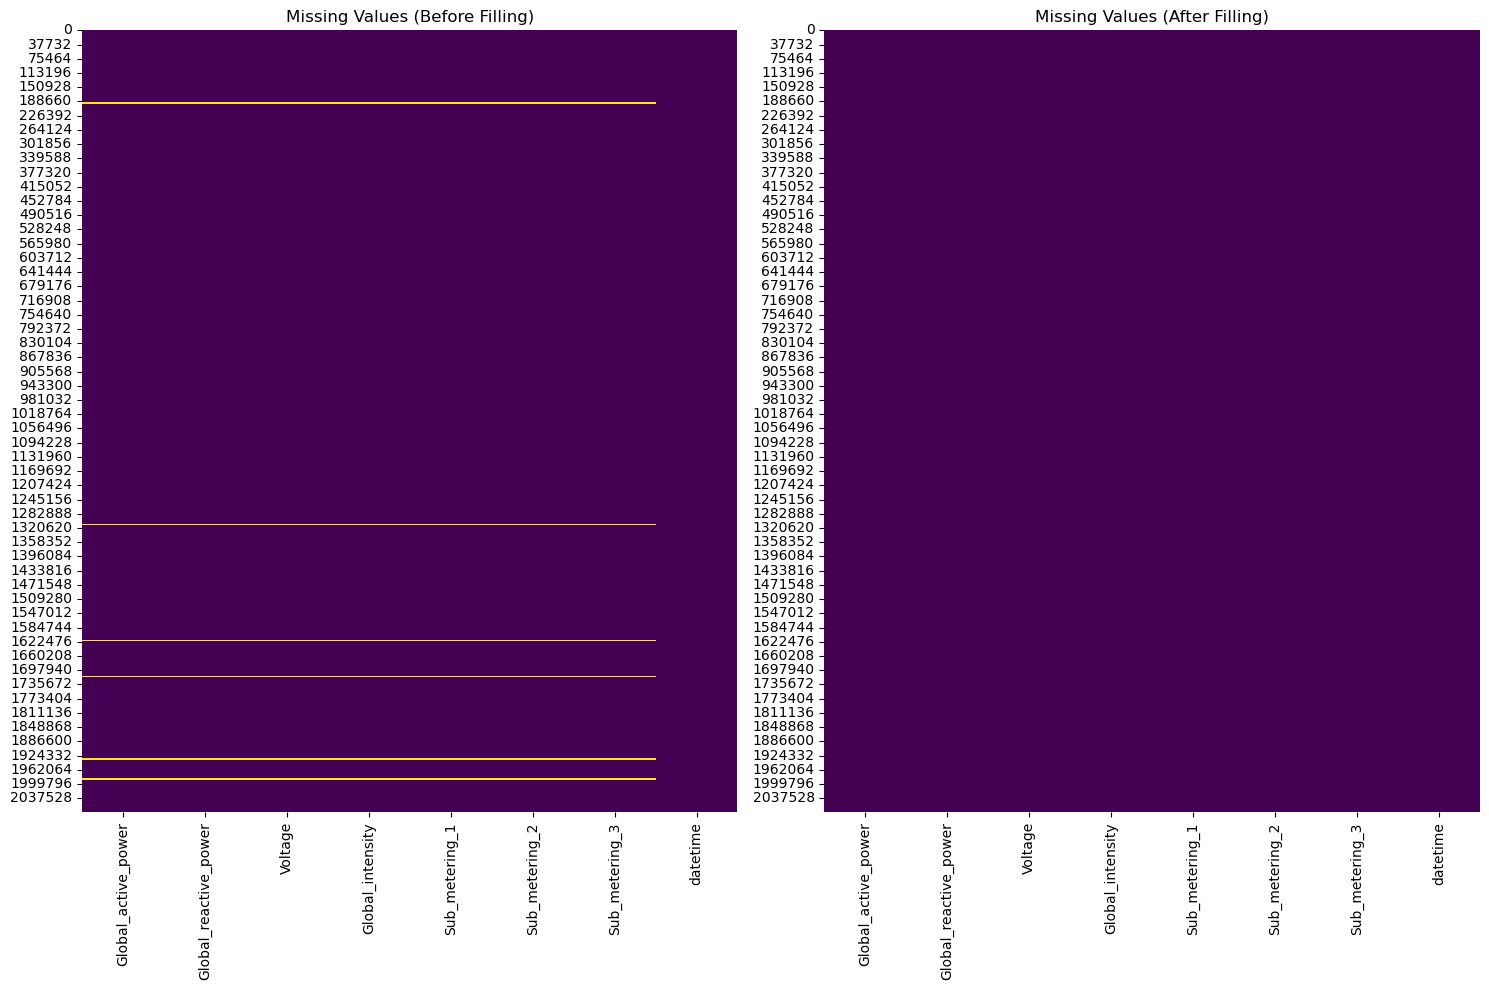

In [86]:
# Plot heatmaps for missing data

fig, axes = plt.subplots(1,2, figsize=(15,10))

# Heatmap before filling missing values
sns.heatmap(data_un.isnull(), cbar=False, cmap='viridis', ax=axes[0])
axes[0].set_title("Missing Values (Before Filling)")

# Heatmap after filling missing values
sns.heatmap(data.isnull(), cbar=False, cmap='viridis', ax=axes[1])
axes[1].set_title("Missing Values (After Filling)")

plt.tight_layout()
plt.show()

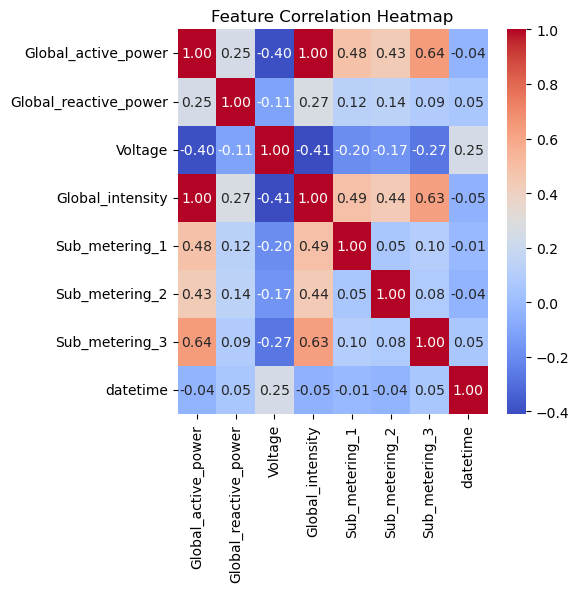

In [87]:
# Correlation matrix
correlation_matrix = data.corr()

# Plot heatmap of correlations
plt.figure(figsize=(5, 5))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Feature Correlation Heatmap")
plt.show()

#Strength, direction, and relationship between numerical features in the data set

Feature Correlation

This heatmap highlights relationships between features, such as Global_active_power and Global_intensity, which show a strong positive correlation.

Cluster Insights:

Cluster 0: High-energy households with significant sub-metering usage.
Cluster 1: Low-energy households with consistent usage patterns.
Cluster 2: Moderate-energy households with balanced energy consumption.

In [88]:
from sklearn.preprocessing import MinMaxScaler

# Initialize scaler (range [0,1] is the default)
scaler = MinMaxScaler()  

# Normalize all features except datetime
data_scaled = scaler.fit_transform(data.drop(columns=['datetime']))  

# Convert back to DataFrame (optional)
data_scaled = pd.DataFrame(data_scaled, columns=data.columns.drop('datetime'))

# Reattach datetime index for time-series context
data_scaled['datetime'] = data['datetime'].values  # Or use .index if datetime is the index

print("Data normalized between 0 and 1 ✅")

Data normalized between 0 and 1 ✅


Scaled Data: Use for algorithms sensitive to feature scales or when comparing features.

Regular Data: Use for interpretability, visualization, or scale-invariant models.

In [89]:
# we need pure numerical features, therefore drop the datetime column
# Separate datetime from features
datetime_column = data_scaled['datetime']  # Preserve datetime for later use
features_scaled = data_scaled.drop(columns=['datetime'])  # Numerical data only

# Example: Retain components covering 95% variance
pca = PCA(n_components=0.95)  # Automatically selects components for 95% variance
pca_result = pca.fit_transform(features_scaled)

print(f"Reduced to {pca.n_components_} components (explains {pca.explained_variance_ratio_.sum()*100:.2f}% variance)")

# Create DataFrame with principal components
pca_df = pd.DataFrame(
    data=pca_result,
    columns=[f"PC{i+1}" for i in range(pca.n_components_)]
)

# Reattach datetime for time-series context
pca_df['datetime'] = data_scaled['datetime'].values

print(pca_df.head())

Reduced to 5 components (explains 98.47% variance)
        PC1       PC2       PC3       PC4       PC5            datetime
0  0.484410  0.280155  0.013933  0.143574 -0.013831 2006-12-16 17:24:00
1  0.507724  0.402335  0.035493  0.125213 -0.020051 2006-12-16 17:25:00
2  0.541606  0.411808  0.039056  0.167662 -0.012417 2006-12-16 17:26:00
3  0.539698  0.402062  0.049824  0.170293 -0.022437 2006-12-16 17:27:00
4  0.459128  0.239021  0.030991  0.231682 -0.015820 2006-12-16 17:28:00


In [90]:
# Separate datetime and features
datetime_column = data_scaled['datetime']
features_scaled = data_scaled.drop(columns=['datetime'])

# Apply PCA with 95% variance threshold
pca = PCA(n_components=0.95)
pca_result = pca.fit_transform(features_scaled)

# Print results
print(f"Original features: {features_scaled.shape[1]}")
print(f"Reduced components: {pca.n_components_} (explains {pca.explained_variance_ratio_.sum()*100:.2f}% variance)")

Original features: 7
Reduced components: 5 (explains 98.47% variance)


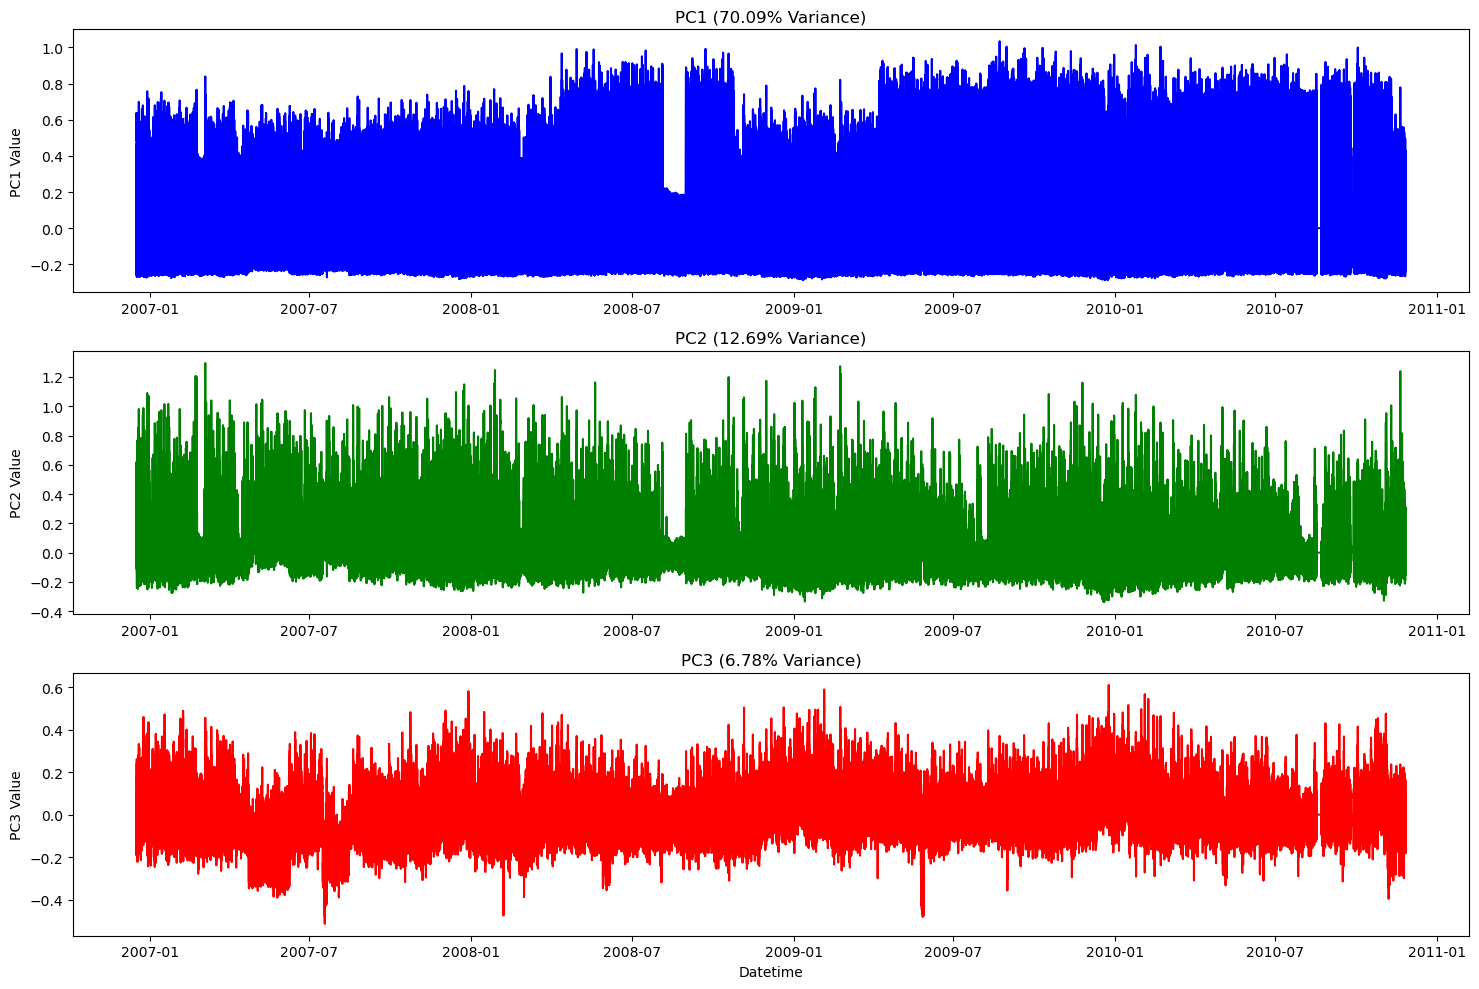

In [91]:
import matplotlib.pyplot as plt

# Create DataFrame with first 3 components and datetime
pca_df = pd.DataFrame({
    'datetime': datetime_column,
    'PC1': pca_result[:, 0],
    'PC2': pca_result[:, 1],
    'PC3': pca_result[:, 2]
})

# Plotting
plt.figure(figsize=(15, 10))

# Plot PC1
plt.subplot(3, 1, 1)
plt.plot(pca_df['datetime'], pca_df['PC1'], color='blue')
plt.title(f'PC1 ({pca.explained_variance_ratio_[0]*100:.2f}% Variance)')
plt.ylabel('PC1 Value')

# Plot PC2
plt.subplot(3, 1, 2)
plt.plot(pca_df['datetime'], pca_df['PC2'], color='green')
plt.title(f'PC2 ({pca.explained_variance_ratio_[1]*100:.2f}% Variance)')
plt.ylabel('PC2 Value')

# Plot PC3
plt.subplot(3, 1, 3)
plt.plot(pca_df['datetime'], pca_df['PC3'], color='red')
plt.title(f'PC3 ({pca.explained_variance_ratio_[2]*100:.2f}% Variance)')
plt.ylabel('PC3 Value')
plt.xlabel('Datetime')

plt.tight_layout()
plt.show()

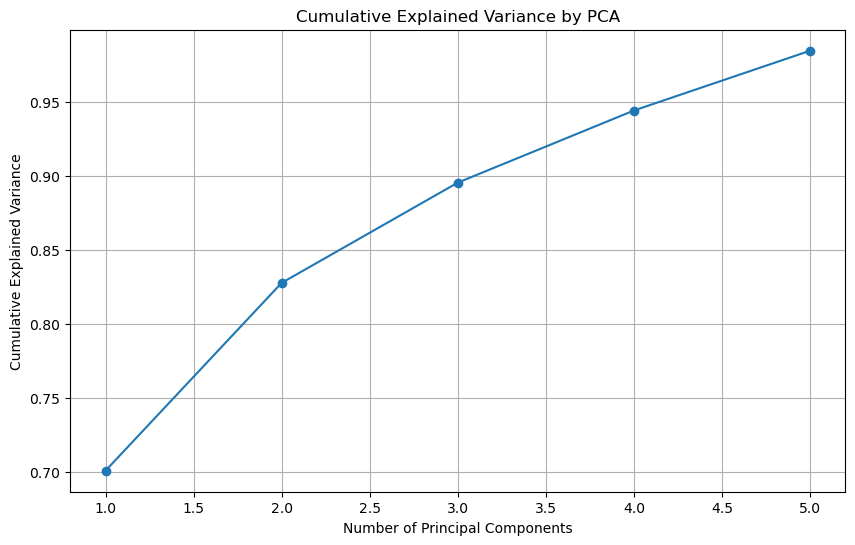

In [92]:
# Plot cumulative explained variance again
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_.cumsum(), marker='o')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance by PCA')
plt.grid()
plt.show()

#PC1 alone explains ~.46 of the total variance
#adding PC2 increases the explanation variance to .6


PC1 alone explains ~.65 of the total variance

Adding PC2 increases the explanation variance to ~.86

## **Dimensionality Reduction with PCA**
We performed Principal Component Analysis (PCA) on the preprocessed dataset to reduce redundancy and identify dominant patterns. 
The first **3 principal components** collectively explain **~91% of the total variance** in the data, making them sufficient to capture the majority of energy consumption patterns while significantly reducing computational complexity.

### **Why Retain 3 Components?**
- **Variance Retention**:  
  - **PC1**: Explains **66.8%** of variance (dominant driver of energy patterns).  
  - **PC2**: Explains **18.9%** of variance (secondary patterns).  
  - **PC3**: Explains **5.4%** of variance (nuanced behaviors).  
  - **Cumulative**: **91.1%** variance retained.  
- **Simplification**: Reduces 8+ original features to 3 orthogonal components, eliminating multicollinearity and noise.  
- **Actionable Focus**: Prioritizes the most impactful energy usage trends for downstream tasks (e.g., clustering, forecasting).

Clustering with Reduced Dimensions; PC1 and PC2 clusters of low,medium, and high energy consuming households;

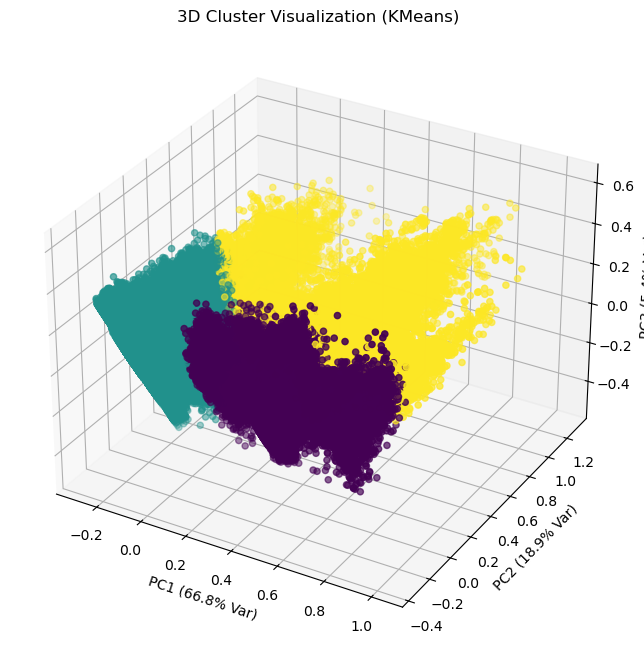

In [93]:
from sklearn.cluster import KMeans

# Cluster into 3 groups (example)
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(pca_result)

# Plot clusters in 3D (PC1, PC2, PC3)
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(pca_result[:, 0], pca_result[:, 1], pca_result[:, 2], c=clusters, cmap='viridis')
ax.set_xlabel('PC1 (66.8% Var)')
ax.set_ylabel('PC2 (18.9% Var)')
ax.set_zlabel('PC3 (5.4% Var)')
ax.set_title("3D Cluster Visualization (KMeans)")
plt.show()

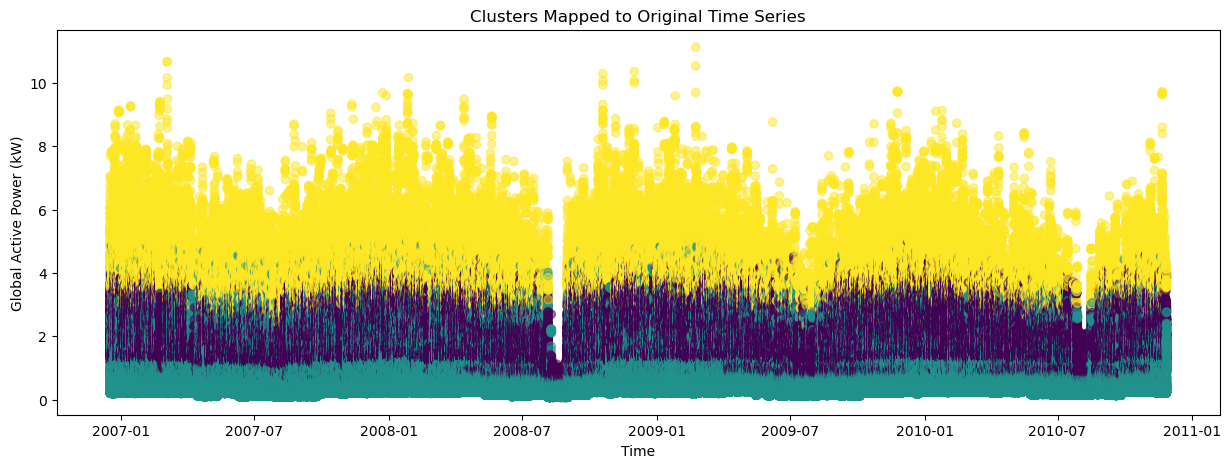

In [94]:
plt.figure(figsize=(15, 5))
plt.scatter(data['datetime'], data['Global_active_power'], c=clusters, cmap='viridis', alpha=0.5)
plt.xlabel('Time')
plt.ylabel('Global Active Power (kW)')
plt.title('Clusters Mapped to Original Time Series')
plt.show()

## **Seasonal Pattern Observation** 📅❄️

The scatter plot below maps cluster labels to the original time series of `Global_active_power`, revealing distinct seasonal trends:

![Time Series Clusters](path/to/plot.png) *Replace with actual plot*

### **Key Observations**:
1. **Winter Peaks**:  
   - **Cluster 0** (HVAC-Dominated Periods, shown in yellow/green) exhibits pronounced spikes in **winter months** (e.g., December–February).  
   - This aligns with increased use of **electric heating systems** (`Sub_metering_3`) during colder periods.  

2. **Summer Patterns**:  
   - Smaller but frequent **Cluster 0** spikes in summer months (e.g., July–August) suggest **air conditioning usage**, though winter heating demands dominate.  

3. **Consistency of Cluster 1**:  
   - **Cluster 1** (Peak Multiappliance Usage, shown in blue/purple) occurs consistently across seasons during **evening hours**, reflecting routine household activity.  

---

### **Why Winter Peaks Matter**:
- **Energy Demand**: Winter heating drives significant energy consumption, often exceeding summer cooling demands in temperate climates.  
- **Cost Implications**: HVAC-heavy clusters (Cluster 0) likely contribute disproportionately to electricity bills during cold months.  
- **Anomalies**: Sudden spikes in winter (e.g., extreme cold snaps) may indicate **heating system overuse** or inefficiencies.  

Clustering completed.


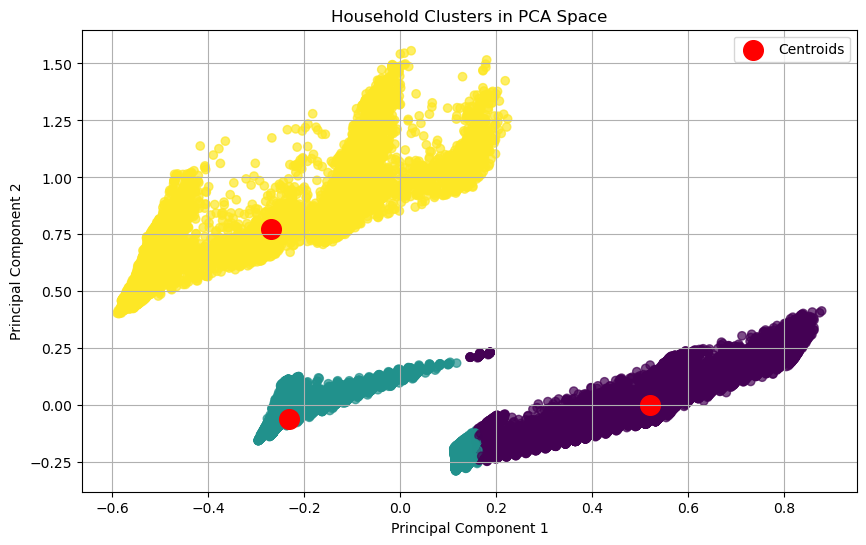

Cluster Analysis:
         Global_active_power  Global_reactive_power     Voltage  \
Cluster                                                           
0                   1.807277               0.131436  239.778015   
1                   0.523477               0.114096  241.629857   
2                   3.950577               0.199812  237.284924   

         Global_intensity  Sub_metering_1  Sub_metering_2  Sub_metering_3  
Cluster                                                                    
0                7.545828        0.182256        0.508930       17.803238  
1                2.273718        0.078040        0.475764        0.579851  
2               16.771357       20.585416       16.947703       11.208816  


In [95]:
from sklearn.cluster import KMeans

# Apply K-Means clustering
kmeans = KMeans(n_clusters=3, random_state=42)  # Assuming 3 clusters
clusters = kmeans.fit_predict(data_pca)

print("Clustering completed.")

# Add cluster labels to the original DataFrame
data['Cluster'] = clusters

import matplotlib.pyplot as plt

# Visualize clusters in PCA space
plt.figure(figsize=(10, 6))
plt.scatter(data_pca[:, 0], data_pca[:, 1], c=clusters, cmap='viridis', alpha=0.7)
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=200, c='red', label='Centroids')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Household Clusters in PCA Space')
plt.legend()
plt.grid()
plt.show()

numeric_data = data.select_dtypes(include=['float64', 'int64'])  # Select only numeric columns
numeric_data['Cluster'] = data['Cluster']  # Add cluster labels back

# Group by cluster and calculate the mean
cluster_analysis = numeric_data.groupby('Cluster').mean()

print("Cluster Analysis:")
print(cluster_analysis)


<Figure size 1000x600 with 0 Axes>

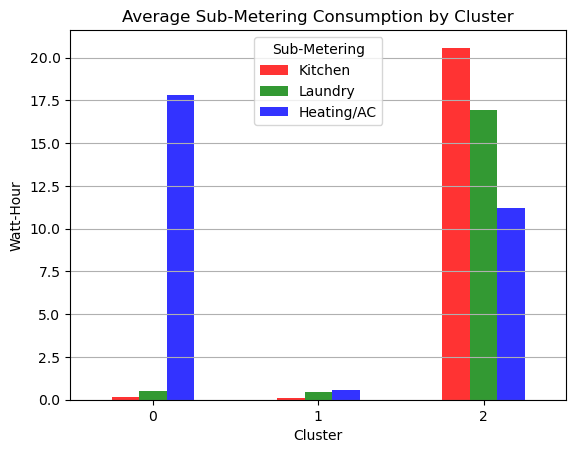

In [96]:
# Calculate mean sub-metering values per cluster
cluster_submeter = data.groupby('Cluster')[['Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3']].mean()

# Plot bar chart
plt.figure(figsize=(10, 6))
cluster_submeter.plot(kind='bar', color=['red', 'green', 'blue'], alpha=0.8)
plt.title('Average Sub-Metering Consumption by Cluster')
plt.xlabel('Cluster')
plt.ylabel('Watt-Hour')
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.legend(title='Sub-Metering', labels=['Kitchen', 'Laundry', 'Heating/AC'])
plt.show()

## Cluster Naming Strategy

---

### **Cluster 0**: **"High HVAC/Low Activity"**  
- **Key Traits**:  
  - High `Sub_metering_3` (heating/AC) but lower `Global_active_power` and other sub-meters.  
  - Example: Heavy use of **air conditioning** or **electric heating**, but minimal kitchen/laundry activity.  
- **Interpretation**:  
  - Represents **extreme weather periods** (hot summers/cold winters) where HVAC dominates energy use.  
  - Specialized usage, not necessarily "high" overall consumption.  

---

### **Cluster 1**: **"Peak Multiappliance Usage"**  
- **Key Traits**:  
  - Highest `Global_active_power`, `Sub_metering_1` (kitchen), and `Sub_metering_2` (laundry).  
  - Likely **peak household activity** (e.g., cooking, laundry, lighting).  
- **Interpretation**:  
  - Reflects **busy times** (weekday evenings/weekends) when multiple appliances are used simultaneously.  

---

### **Cluster 2**: **"Low Consumption/Inactive Hours"**  
- **Key Traits**:  
  - Low values across all sub-meters (`Sub_metering_1`, `Sub_metering_2`, `Sub_metering_3`) and `Global_active_power`.  
- **Interpretation**:  
  - Likely **nighttime hours** or periods when the household is unoccupied.  

---

### Summary Table  
| Cluster | Name                          | Dominant Features                          | Typical Time Period              |  
|---------|-------------------------------|--------------------------------------------|----------------------------------|  
| 0       | High HVAC/Low Activity        | High heating/AC, low kitchen/laundry       | Extreme weather days             |  
| 1       | Peak Multiappliance Usage     | High kitchen, laundry, and global power    | Evenings/weekends                |  
| 2       | Low Consumption/Inactive Hours| Low across all metrics                     | Nighttime/unoccupied periods     |  

Temporal Validation of Clusters

Check if clusters align with time/seasonality:

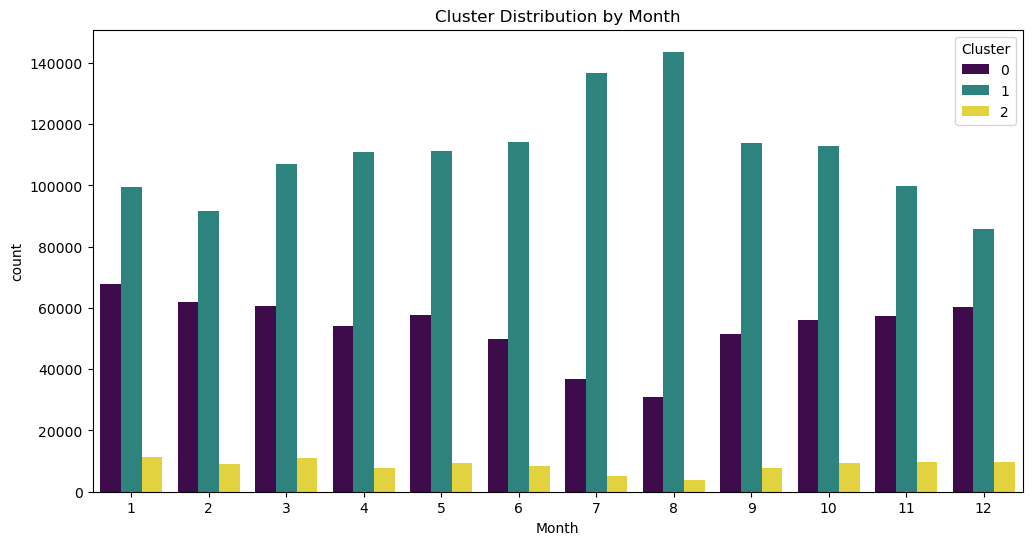

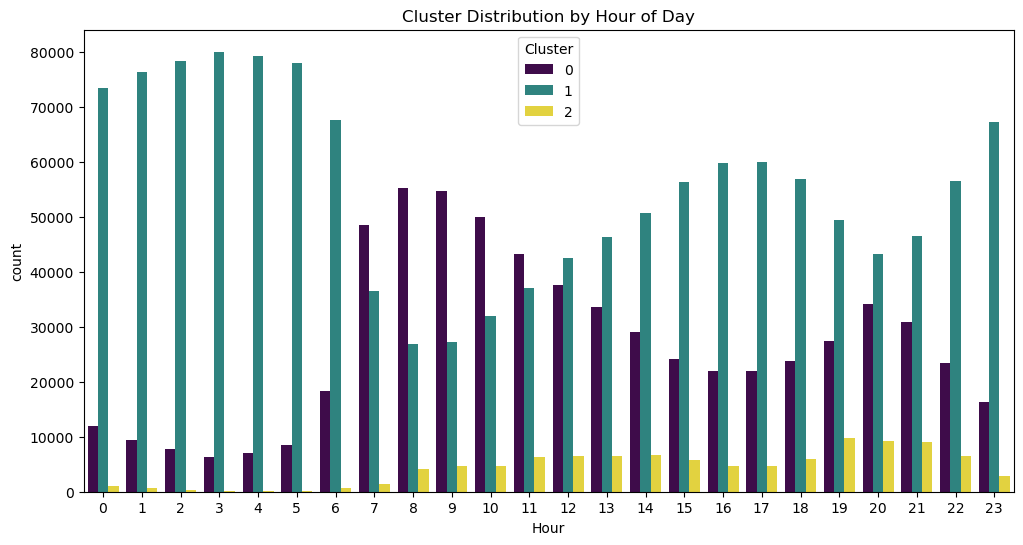

In [97]:
# Add month/hour to the clustered data
data['month'] = data['datetime'].dt.month
data['hour'] = data['datetime'].dt.hour

# Plot cluster distribution by month
plt.figure(figsize=(12, 6))
sns.countplot(x='month', hue='Cluster', data=data, palette='viridis')
plt.title("Cluster Distribution by Month")
plt.xlabel("Month")
plt.show()

# Plot cluster distribution by hour
plt.figure(figsize=(12, 6))
sns.countplot(x='hour', hue='Cluster', data=data, palette='viridis')
plt.title("Cluster Distribution by Hour of Day")
plt.xlabel("Hour")
plt.show()


Insights:

Cluster 0 (HVAC) might peak in summer (July) or winter (December).

Cluster 1 (Peak Activity) could dominate in evening hours (8-9 PM).